In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from keras.utils import plot_model, model_to_dot
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [ ]:
dataset = pd.read_csv(r"C:\Users\aades\Downloads\LSTM_Experiment\LSTM_Experiment\Datasets\datasets_56102_107707_monthly-beer-production-in-austr.csv")

dataset["Month"] = pd.to_datetime(dataset["Month"])
dataset["Monthly beer production"] = dataset["Monthly beer production"].astype(float)

data = dataset["Monthly beer production"].to_numpy().reshape((len(dataset["Monthly beer production"]), 1))

In [ ]:
mean_data = np.mean(data)
std_data = np.std(data)

def relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

if std_data == 0:
    data_normalized = data - mean_data  
else:
    data_normalized = (data - mean_data) / std_data 

In [ ]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len + 1):
        in_.append(x[i:(i + train_len), feature_cols].tolist())
        out_.append(x[(i + train_len):(i + train_len + test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

X_in, X_out = truncate(data, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=12, test_len=1)

train_x = X_in[:math.floor(X_in.shape[0] * 0.70)]
train_y = X_out[:math.floor(X_out.shape[0] * 0.70)]
test_x = X_in[math.floor(X_in.shape[0] * 0.70):]
test_y = X_out[math.floor(X_out.shape[0] * 0.70):]
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)


In [ ]:
def quantile_loss(quantile):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(quantile * e, (quantile - 1) * e), axis=-1)
    return loss

In [ ]:
def create_lstm(input_shape, layers, output_dim, dropout_rates):
    initializer = tf.keras.initializers.GlorotNormal(seed=None)
    input_train = Input(shape=input_shape)

    x = input_train
    for i, units in enumerate(layers):
        return_sequences = i < len(layers) - 1 
        x = LSTM(units, activation='relu', kernel_initializer=initializer, return_sequences=return_sequences)(x)

        dropout_rate = dropout_rates[i] if i < len(dropout_rates) else 0.0
        x = Dropout(dropout_rate)(x)
    out = Dense(output_dim)(x)
    
    model = Model(inputs=input_train, outputs=out)
    return model

layers = [64, 32]
dropout_rates = [0]
quantile1 = create_lstm((12,1),layers,1,dropout_rates)
quantile2 = create_lstm((12,1),layers,1,dropout_rates)

(324, 12, 1) (140, 12, 1) (324, 1, 1) (140, 1, 1)


c:\Users\aades\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [26]:

q1 = 0.018 #0.011 
q2 = 0.968 #0.961
quantile1.compile(loss=quantile_loss(q1),optimizer=Adam(learning_rate=0.01))
quantile2.compile(loss=quantile_loss(q2),optimizer=Adam(learning_rate=0.01))

In [ ]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()
epc = 300
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')

start_time = datetime.datetime.now()
history = quantile1.fit(train_x, train_y,validation_split=0.1, epochs=epc, verbose=1, batch_size=64, 
                         callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time1 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken:', total_time1,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))

In [ ]:

stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
start_time = datetime.datetime.now()
history = quantile2.fit(train_x, train_y, epochs=epc, verbose=1, batch_size=64, validation_split=0.1,
                         callbacks=[early_stopping])
end_time = datetime.datetime.now()
total_time2 = round((end_time - start_time).total_seconds(), 2)
print('seconds taken:', total_time2,
      '\nstart_time:', start_time.strftime('%H:%M:%S'),
      'end_time:', end_time.strftime('%H:%M:%S'))

In [ ]:
# Predicting and calculating PICP and MPIW
y_l_pred = quantile1.predict(test_x, verbose=0)
y_u_pred = quantile2.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:, 0])
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
PICP = np.mean(K_u * K_l)
MPIW = np.round(np.mean(y_u_pred - y_l_pred), 3)
print('PICP:', PICP)
print('MPIW:', MPIW)


Epoch 1/300
5/5 [==============================] - 3s 106ms/step - loss: 2.5719 - val_loss: 2.5126
Epoch 2/300
5/5 [==============================] - 0s 18ms/step - loss: 2.0828 - val_loss: 1.9198
Epoch 3/300
5/5 [==============================] - 0s 18ms/step - loss: 1.3073 - val_loss: 1.4650
Epoch 4/300
5/5 [==============================] - 0s 17ms/step - loss: 2.2672 - val_loss: 1.9349
Epoch 5/300
5/5 [==============================] - 0s 21ms/step - loss: 1.8138 - val_loss: 2.6079
Epoch 6/300
5/5 [==============================] - 0s 24ms/step - loss: 1.9987 - val_loss: 2.3248
Epoch 7/300
5/5 [==============================] - 0s 19ms/step - loss: 1.3139 - val_loss: 1.5513
Epoch 8/300
5/5 [==============================] - 0s 18ms/step - loss: 1.3479 - val_loss: 1.8222
seconds taken: 3.74 
start_time: 18:05:20 end_time: 18:05:23
Epoch 1/300
5/5 [==============================] - 3s 100ms/step - loss: 52.5133 - val_loss: 6.3534
Epoch 2/300
5/5 [==============================] - 0s 

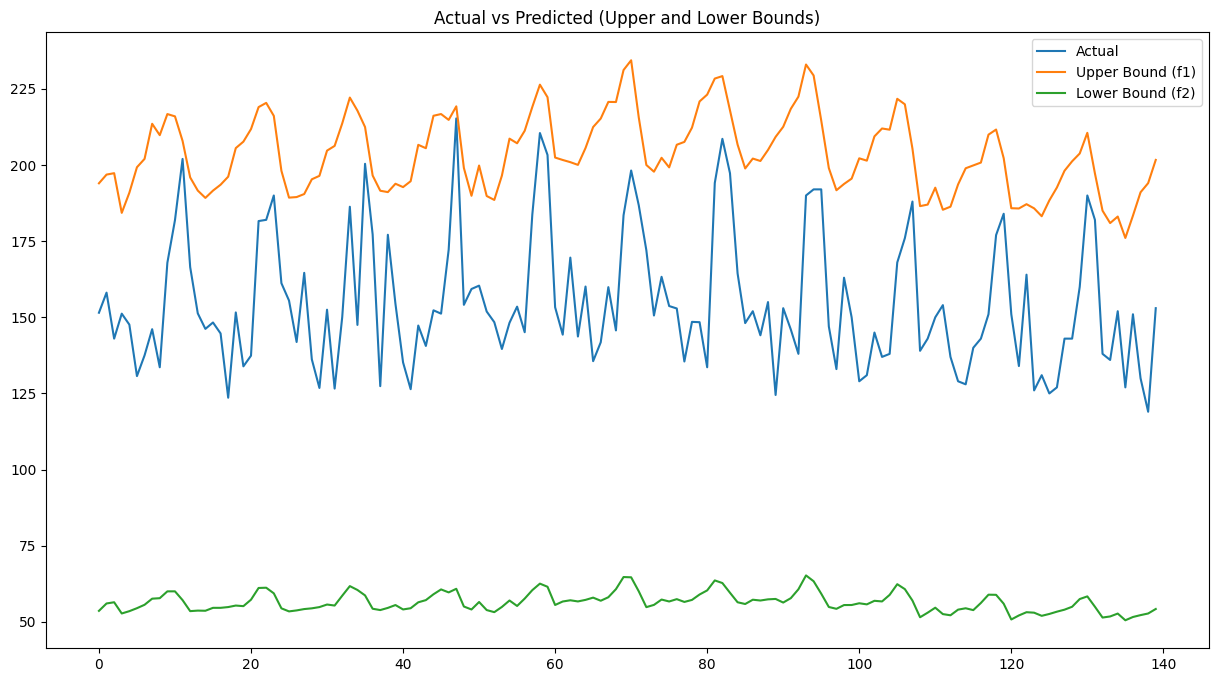

In [28]:
actual = np.squeeze(test_y)
pred1 = y_u_pred
pred2 = y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx, actual, label='Actual')
plt.plot(numEx, pred1, label='Upper Bound (f1)')
plt.plot(numEx, pred2, label='Lower Bound (f2)')
plt.legend(loc='best')
plt.title('Actual vs Predicted (Upper and Lower Bounds)')
plt.show()